**Описание задачи**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 


**Импорт библиотек**

In [1]:
!pip install phik -q

In [2]:
!pip install shap 

In [3]:
!pip install -U scikit-learn 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import os 

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV
)

In [5]:
# Константы

RANDOM_STATE = 42
TEST_SIZE = 0.25

## **Шаг 1. Загрузка данных**

In [ ]:
if os.path.exists('/datasets/market_file.csv'):
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
else:
    market_file = pd.read_csv('Z:\\project\datasets\market_file.csv', sep=',')

if os.path.exists('/datasets/market_money.csv'):
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
else:
    market_money = pd.read_csv('Z:\\project\datasets\market_money.csv', sep=',')
    
if os.path.exists('/datasets/market_file.csv'):
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
else:
    market_time = pd.read_csv('Z:\\project\datasets\market_time.csv', sep=',')
    
if os.path.exists('/datasets/market_file.csv'):
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
else:
    money = pd.read_csv('Z:\\project\datasets\money.csv', sep=',')


**market_file**

In [6]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


**market_money**

In [9]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


**market_time**

In [12]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [13]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


**money**

In [15]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [16]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [17]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


## **Шаг 2. Предобработка данных**

In [18]:
def columns_remove_spaces(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [19]:
columns_remove_spaces(market_file)
columns_remove_spaces(market_money)
columns_remove_spaces(market_time)
columns_remove_spaces(money)

****2.1 Изменение типов данных****

In [20]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Изменим тип данных длительности на float, также изменим маркет_актив_тек_мес на тип float

In [21]:
market_file['длительность'] = market_file['длительность'].astype(float)
market_file['маркет_актив_тек_мес'] = market_file['маркет_актив_тек_мес'].astype(float)

market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   float64
 6   длительность                         1300 non-null   float64
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [22]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [23]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [24]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<s>У прибыли тип данных object, поменяем его</s>

In [25]:
#money['прибыль'] = money['прибыль'].str.replace(',', '.').astype(float)

#money.info()

В таблицах у всех значений верный тип данных

***Вывод*** 

В таблицах все типы данных указаны верно

**2.2 Обработка пропусков**

In [26]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

Пропусков нет

In [27]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

Пропусков нет

In [28]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

Пропусков нет

In [29]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропусков нет

**2.3 Проверка дубликатов**

Начнем с проверки явных дубликатов

In [30]:
market_file.duplicated().sum()

0

In [31]:
market_money.duplicated().sum()

0

In [32]:
market_time.duplicated().sum()

0

In [33]:
money.duplicated().sum()

0

Явные дубликаты отсутсвуют. Проверим неявные

In [34]:
def check_duplicated(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            display(f'В столбце {column} следующие уникальные значения: {data[column].unique()}')

In [35]:
check_duplicated(market_file)

"В столбце покупательская_активность следующие уникальные значения: ['Снизилась' 'Прежний уровень']"

"В столбце тип_сервиса следующие уникальные значения: ['премиум' 'стандартт' 'стандарт']"

"В столбце разрешить_сообщать следующие уникальные значения: ['да' 'нет']"

"В столбце популярная_категория следующие уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'\n 'Техника для красоты и здоровья' 'Кухонная посуда'\n 'Мелкая бытовая техника и электроника']"

Видим неявные дубликаиы в столбце Тип сервиса, исправим

In [36]:
market_file['тип_сервиса'].replace('стандартт', 'стандарт', inplace=True) 
market_file['популярная_категория'].replace('Косметика и аксесуары', 'Косметика и аксессуары', inplace=True) 

In [37]:
check_duplicated(market_file)

"В столбце покупательская_активность следующие уникальные значения: ['Снизилась' 'Прежний уровень']"

"В столбце тип_сервиса следующие уникальные значения: ['премиум' 'стандарт']"

"В столбце разрешить_сообщать следующие уникальные значения: ['да' 'нет']"

"В столбце популярная_категория следующие уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'\n 'Техника для красоты и здоровья' 'Кухонная посуда'\n 'Мелкая бытовая техника и электроника']"

Неявный дубликат удален. Также исправлено неверное написание категории

In [38]:
check_duplicated(market_money)

"В столбце период следующие уникальные значения: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']"

In [39]:
check_duplicated(market_time)

"В столбце период следующие уникальные значения: ['текущий_месяц' 'предыдцщий_месяц']"

Есть ошибка в написании категории

In [40]:
market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)

In [41]:
check_duplicated(market_time)

"В столбце период следующие уникальные значения: ['текущий_месяц' 'предыдущий_месяц']"

***Вывод***

Были найдены неявные дубликаты в таблице market_file, также были найдены опечатки в столбце таблицы market_time

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Речь про слово "аксессуар" или про слово "предпредыдущий"?</div>

## **Шаг 3. Исследовательский анализ данных**

Создадим 2 функции, одна будет выводить круговые диаграммы для всех категориальных признаков, вторая - для числовых

In [42]:
def visualize_data_categorial(data):
    
    for column in data.columns:
        if data[column].dtype == 'object' or (data[column].dtype == 'int64' and column != 'id'):
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
            sns.countplot(x=column, data=data, ax=axes[0])
            axes[0].tick_params(axis='x', rotation=45)
            axes[0].set_title(f'Гистограмма: {column}')
            
            axes[1].pie(data[column].value_counts(), labels=data[column].value_counts().index, autopct='%1.1f%%')
            axes[1].set_title(f'Круговая диаграмма: {column}')

            plt.show()
            
def visualize_data_num_continuous(data):
    for column in data.columns:  
        
        if data[column].dtype == 'int64' and column != 'id':
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
            sns.countplot(x=column, data=data, ax=axes[0])
            axes[0].tick_params(axis='x', rotation=45)
            axes[0].set_title(f'Гистограмма: {column}')

            sns.boxplot(x=data[column], ax=axes[1])
            axes[1].set_title(f'Ящик с усами {column}')
            axes[1].set_xlabel(column)

            plt.show()

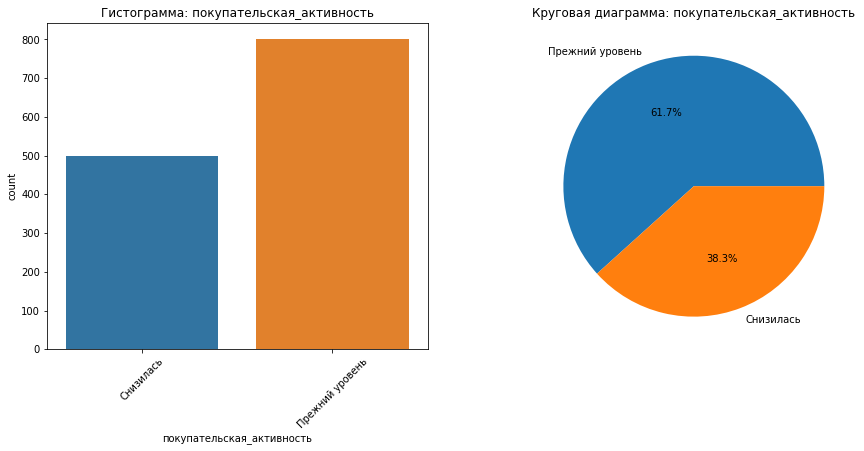

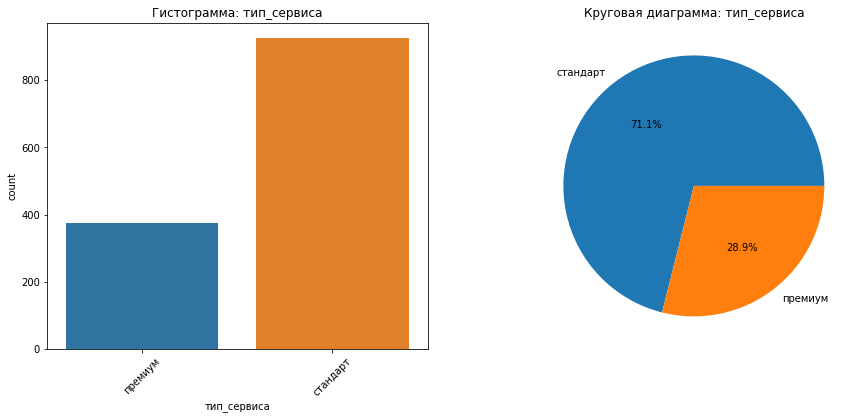

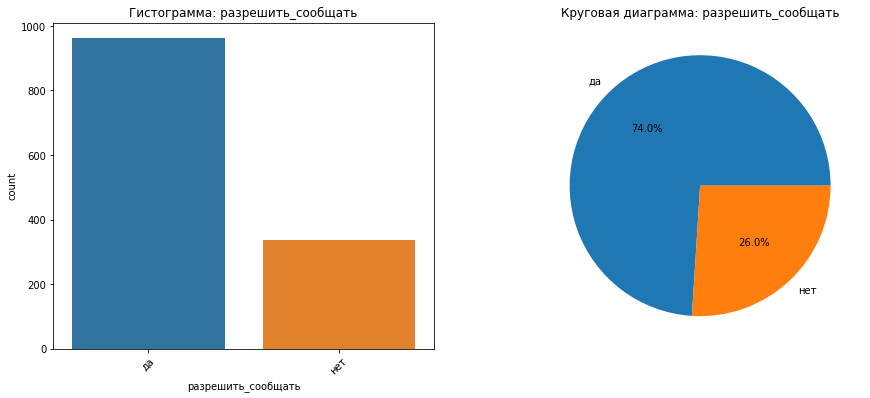

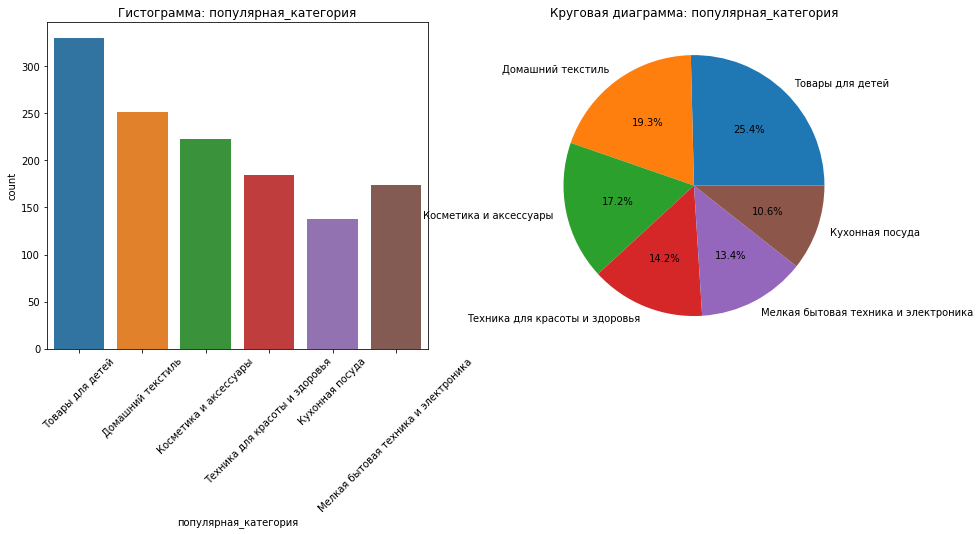

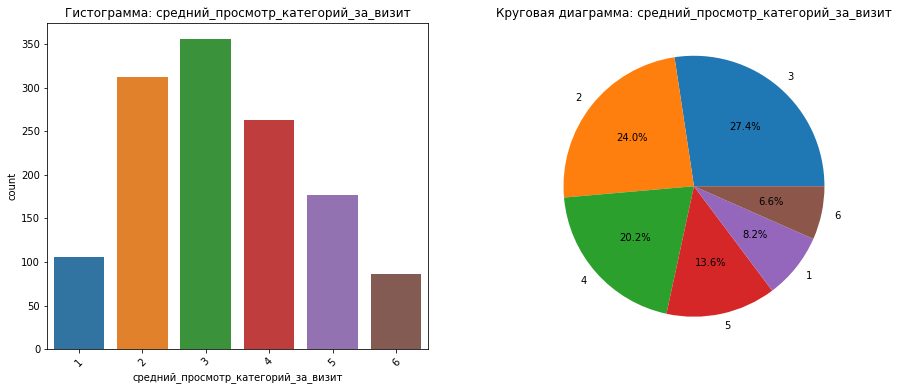

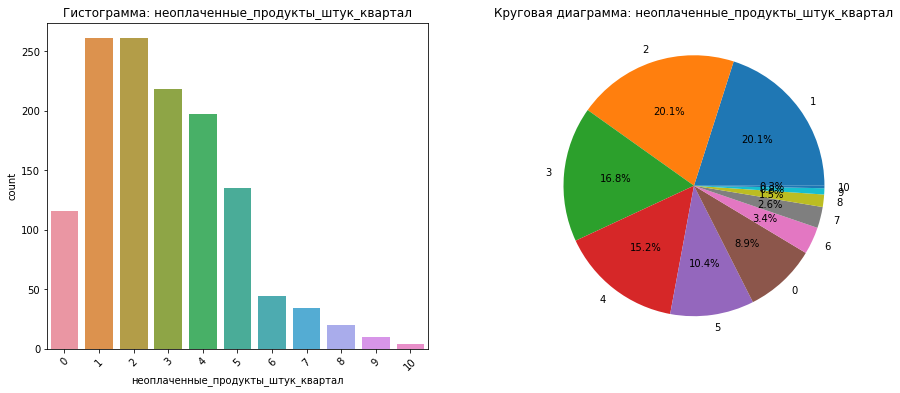

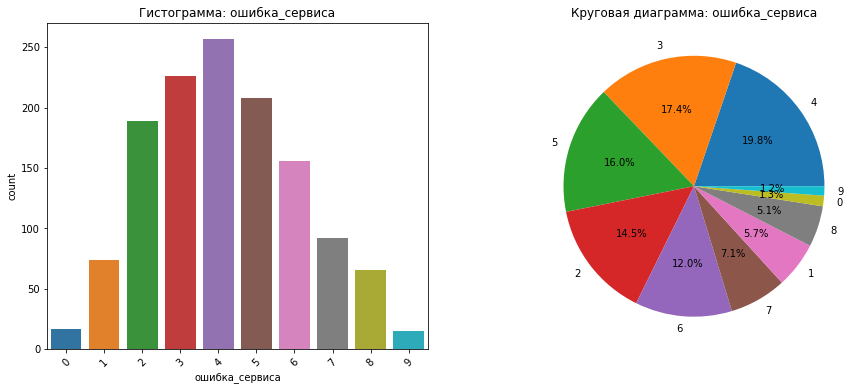

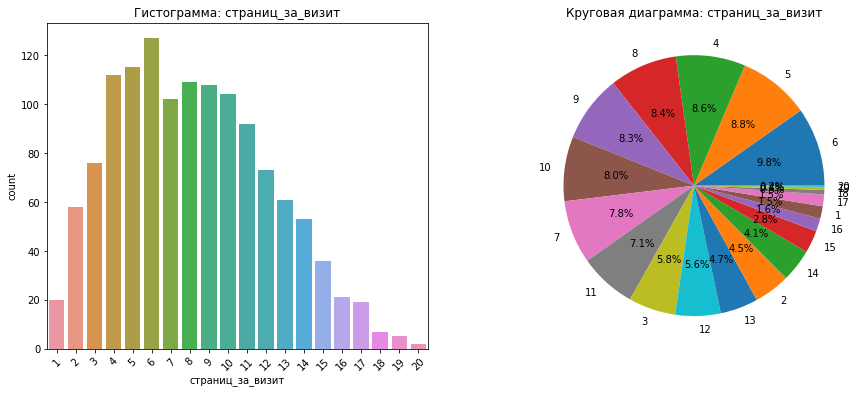

In [43]:
visualize_data_categorial(market_file)

Посмотрев на данные диаграммы можно сделать следующие выводы:

1. Покупательская активность в 61% случаев осталась прежней
2. У 71% пользователей стандартный тип сервиса
3. 74% пользователей можно отправлять дополнительные предложения
4. Явного фаворита в популярных категориях нет

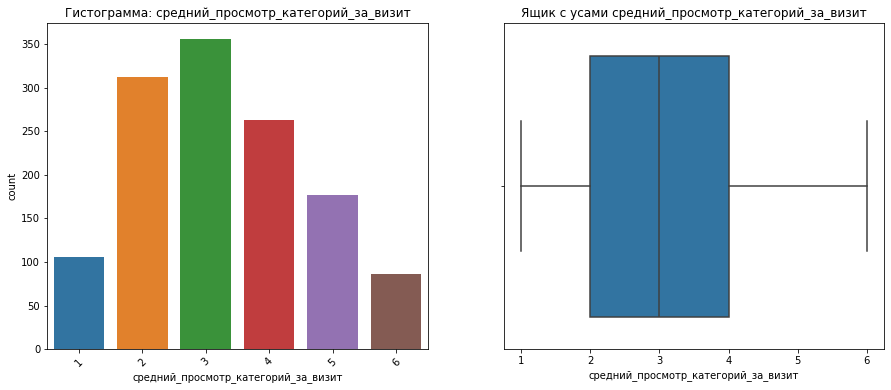

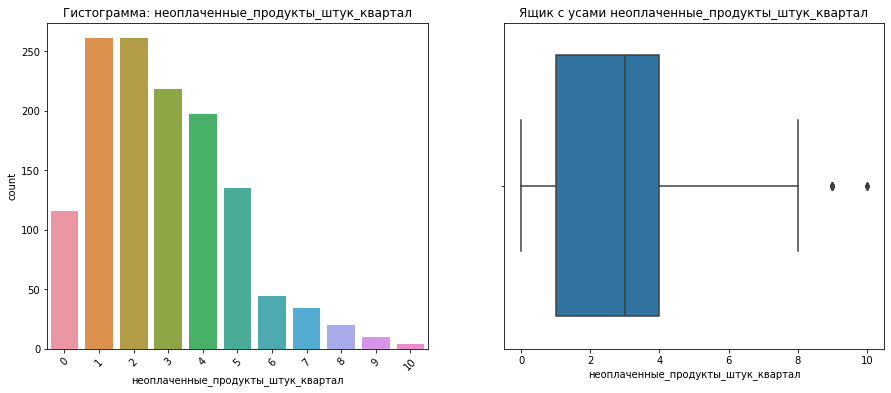

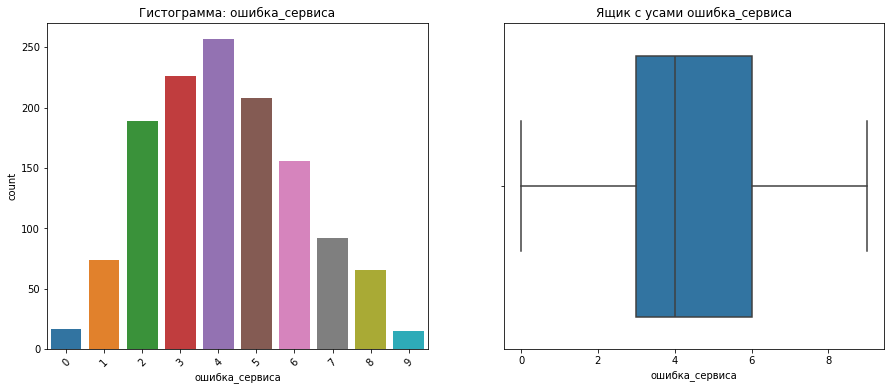

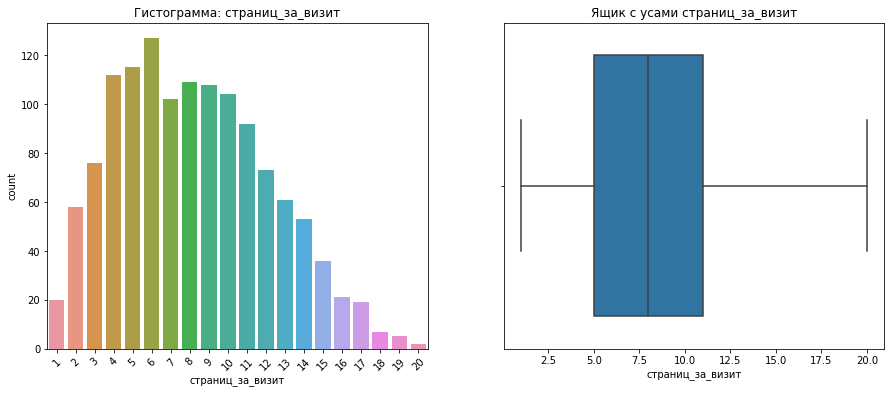

In [44]:
visualize_data_num_continuous(market_file)

В данных нет выбросов

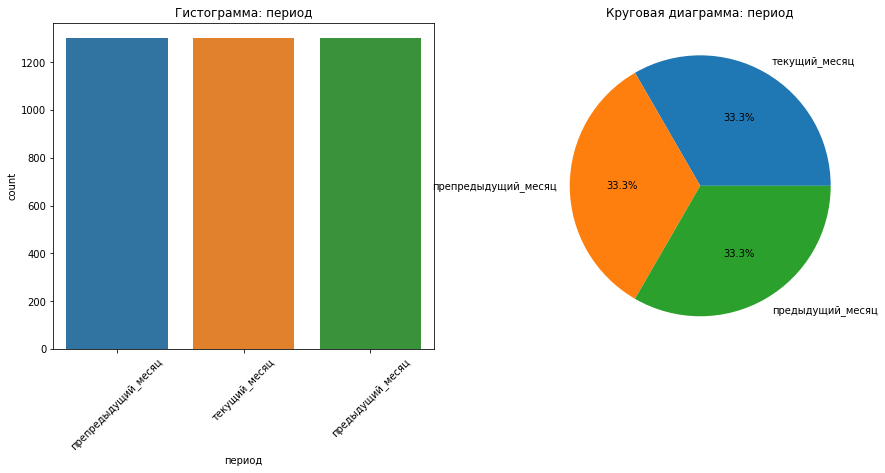

In [45]:
visualize_data_categorial(market_money)

In [46]:
visualize_data_num_continuous(market_money)

Есть четкий выброс, уберем его и посмотрим на гистограмму еще раз

In [47]:
# Посмотрим на выброс
market_money[market_money['выручка'] > 100000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [48]:
market_money = market_money[market_money.index != 98]

market_money[market_money['выручка'] > 100000]

,id,период,выручка


Есть также выброс в 0, его тоже удалим

In [49]:
market_money = market_money[market_money['выручка'] > 0]

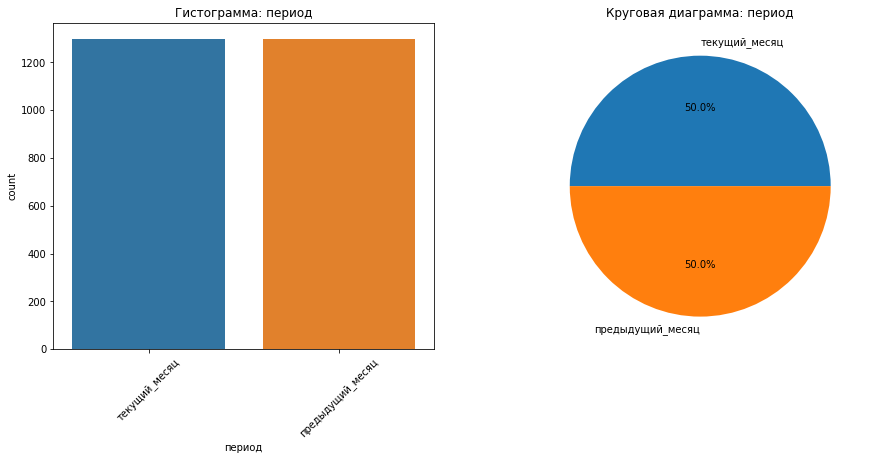

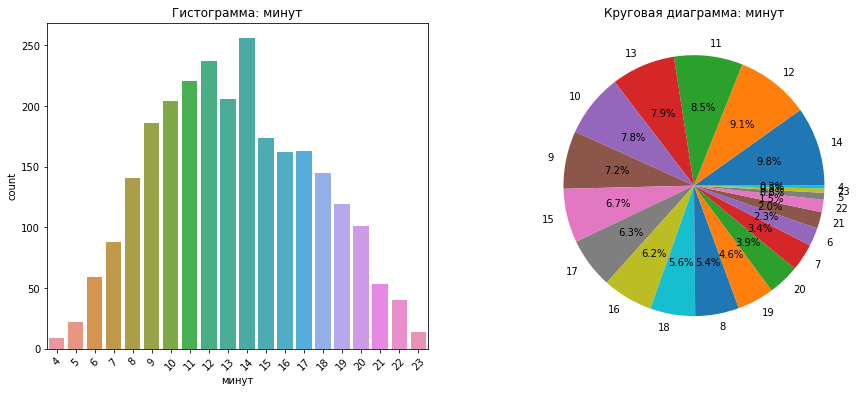

In [50]:
visualize_data_categorial(market_time)

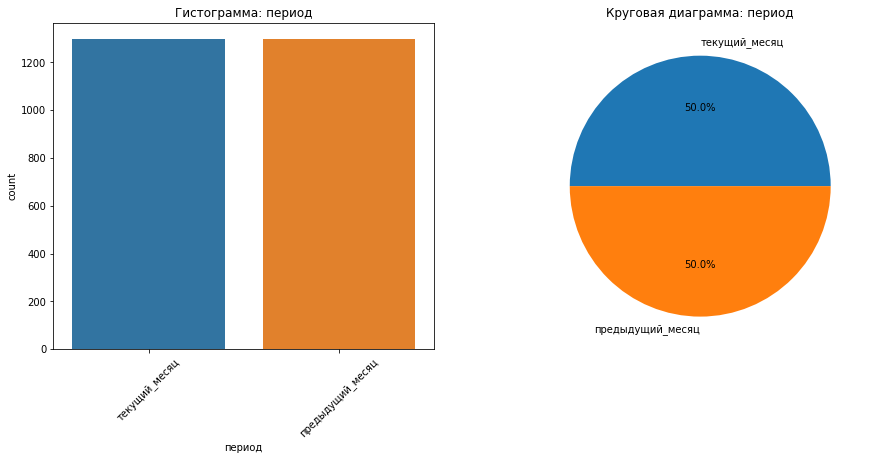

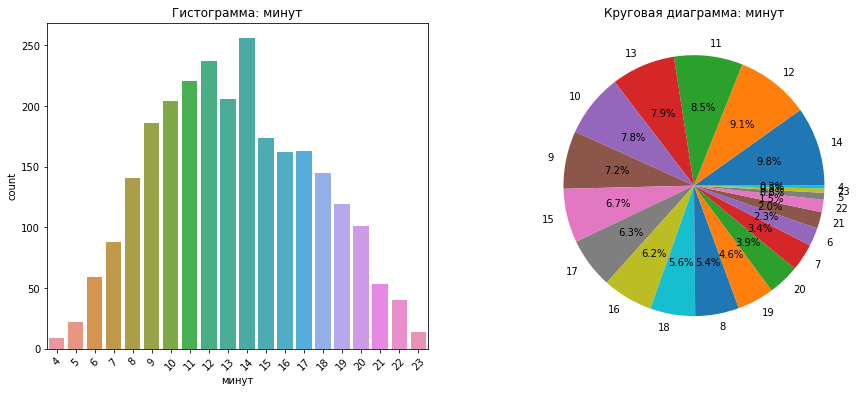

In [51]:
visualize_data_categorial(market_time)

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Не понял, как это можно сделать, чтобы получилось 3 графика.</div>

***Вывод***

1. Покупательская активность в 61% случаев осталась прежней
2. У 71% пользователей стандартный тип сервиса
3. 74% пользователей можно отправлять дополнительные предложения
4. Явного фаворита в популярных категориях нет

Были найдены и устранены выбросы в таблице market_money

## **Шаг 4. Объединение таблиц**

Создадим таблицу market_full, в которую будем поочередно добавлять другие таблицы

In [52]:
market_time_groupped = market_time.pivot_table(index='id', columns='период')
market_time_groupped.columns = ['время_предыдущий_месяц', 'время_препредыдущий_месяц']

market_time_groupped

,время_предыдущий_месяц,время_препредыдущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [53]:
market_money_groupped = market_money.pivot_table(index='id', columns='период')
market_money_groupped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']

market_money_groupped

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [54]:
market_full = market_file.join(market_time_groupped, on='id', how='left')

In [55]:
market_full

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_препредыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5.0,121.0,0.00,Товары для детей,6,2,1,5,13,14
1,215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4,4,2,5,12,10
2,215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5,2,1,5,8,13
3,215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5,0,6,4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3,2,3,2,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3.0,318.0,0.24,Техника для красоты и здоровья,5,3,3,11,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4.0,454.0,0.21,Домашний текстиль,6,2,3,9,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3.0,586.0,0.20,Домашний текстиль,3,2,5,7,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5.0,645.0,0.12,Техника для красоты и здоровья,3,3,5,7,18,7


In [56]:
market_full = market_full.join(market_money_groupped, on='id', how='left')

In [57]:
market_full

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5.0,121.0,0.00,Товары для детей,6,2,1,5,13,14,NaN,NaN,3293.1
1,215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3.0,318.0,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,3664.0,4704.0,4741.7
1296,216644,Прежний уровень,стандарт,нет,5.1,4.0,454.0,0.21,Домашний текстиль,6,2,3,9,12,11,4729.0,5299.0,5353.0
1297,216645,Прежний уровень,стандарт,да,4.1,3.0,586.0,0.20,Домашний текстиль,3,2,5,7,12,18,5160.0,5334.0,5139.2
1298,216646,Прежний уровень,стандарт,да,6.3,5.0,645.0,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4923.0,4725.0,5224.6


Посмотрим на пропуски

In [58]:
market_full.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
время_предыдущий_месяц                 0
время_препредыдущий_месяц              0
выручка_предыдущий_месяц               3
выручка_препредыдущий_месяц            3
выручка_текущий_месяц                  1
dtype: int64

Удалим их, это как раз будут клиенты, которые не пользовались сайтом 3 месяца

In [59]:
market_full = market_full[(market_full['выручка_текущий_месяц'].isna() == False) &
                         (market_full['выручка_предыдущий_месяц'].isna() == False) & 
                         (market_full['выручка_препредыдущий_месяц'].isna() == False)]

In [60]:
market_full.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
время_предыдущий_месяц                 0
время_препредыдущий_месяц              0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
dtype: int64

Избавились от этих пользователей, посмотрим на получившийся фрейм

In [61]:
market_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
5,215353,Снизилась,стандарт,да,3.3,4.0,762.0,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


Сделаем столбец id индексом

In [62]:
market_full = market_full.set_index('id')

In [63]:
market_full

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
215353,Снизилась,стандарт,да,3.3,4.0,762.0,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3.0,318.0,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,3664.0,4704.0,4741.7
216644,Прежний уровень,стандарт,нет,5.1,4.0,454.0,0.21,Домашний текстиль,6,2,3,9,12,11,4729.0,5299.0,5353.0
216645,Прежний уровень,стандарт,да,4.1,3.0,586.0,0.20,Домашний текстиль,3,2,5,7,12,18,5160.0,5334.0,5139.2


***Вывод***

Таблицы были объединены успешно

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Правильно ли я сделал ниже?.</div>

In [64]:
money_pivot_unstack = market_money.set_index(['id', 'период'])['выручка'].unstack()
money_pivot_unstack.columns = [f'выручка_{col}' for col in money_pivot_unstack.columns]

time_pivot_unstack = market_time.set_index(['id', 'период'])['минут'].unstack()
time_pivot_unstack.columns = [f'минут_{col}' for col in time_pivot_unstack.columns]

market_full_2 = market_file.set_index('id').join([money_pivot_unstack, time_pivot_unstack])

market_full_2 = market_full_2.dropna(subset=[
                                             'выручка_текущий_месяц', 
                                             'выручка_предыдущий_месяц', 
                                             'выручка_препредыдущий_месяц']
)

market_full_2

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4.0,819.0,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3.0,539.0,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5.0,896.0,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3.0,1064.0,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4.0,762.0,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3.0,318.0,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
216644,Прежний уровень,стандарт,нет,5.1,4.0,454.0,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
216645,Прежний уровень,стандарт,да,4.1,3.0,586.0,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18


## **Шаг 5. Корелляционный анализ**

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'время_предыдущий_месяц', 'время_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']


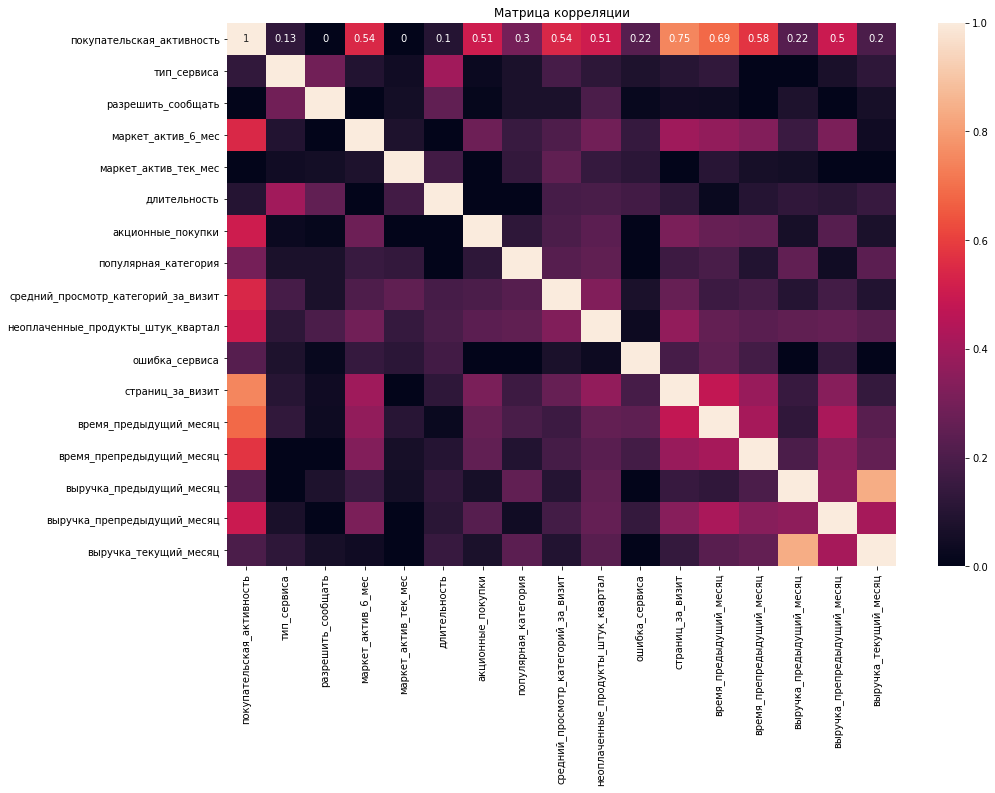

In [65]:
corr_matrix = market_full.phik_matrix()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True)
plt.title('Матрица корреляции')
plt.show()

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Я попробовал размер матрицы поменять, размеры шрифта, ничего не помогло.</div>

Не знаю, почему не подписываются строки, кроме первой.

- Наблюдается зависимость между выручкой предыдущего месяца и текущего
- Также она есть у предыдущего и препредыдущего месяцев
- Также есть завиисмость между посещенными страницами и временем, проведенным на сайте, что логично
- Есть зависимость у минут_предыдущий_месяц и минут_текущий_месяц

<s>Для устранения мультиколлениарности объединим столбцы выручка_препредыдущий_месяц и выручка_предыдущий_месяц в столбце выручка_2_пред_месяца</s>

In [66]:
#market_full['выручка_2_пред_месяца'] = market_full['выручка_предыдущий_месяц'] + market_full['выручка_препредыдущий_месяц']

In [67]:
#corr_matrix = market_full.phik_matrix()
#plt.figure(figsize=(15, 10))
#sns.heatmap(corr_matrix, annot=True)
#plt.title('Матрица корреляции')
#plt.show()

<s>Избавились от мультиколлинеарности </s>

***Вывод***

- Наблюдается зависимость между выручкой предыдущего месяца и текущего
- Также она есть у предыдущего и препредыдущего месяцев
- Также есть завиисмость между посещенными страницами и временем, проведенным на сайте, что логично
- Есть зависимость у минут_предыдущий_месяц и минут_текущий_месяц

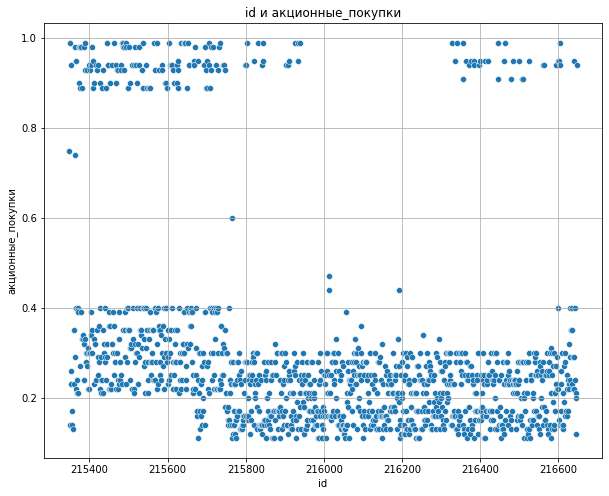

In [68]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=market_full.index, y=market_full['акционные_покупки'])
plt.title("id и акционные_покупки")
plt.xlabel("id")
plt.ylabel("акционные_покупки")
plt.grid(True)
plt.show()

График показывает, что id присвоены не случайно. 

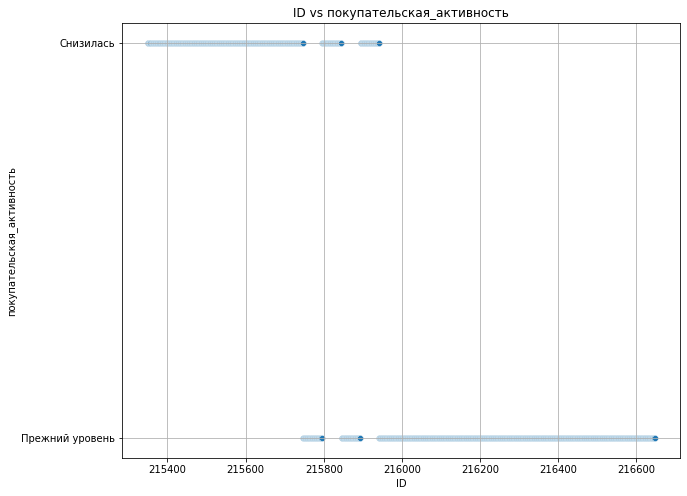

In [69]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=market_full.index, y=market_full['покупательская_активность'])
plt.title("ID vs покупательская_активность")
plt.xlabel("ID")
plt.ylabel("покупательская_активность")
plt.grid(True)
plt.show()

Из этого графика следует, что id присвоены точно не случайно. Пользователи, у который id больше, сохраняют прежний уровень активности.

Если подумать, что больший id присваивается новым пользователям, то получаются следующие выводы.

Из первого графика можно сделать вывод, что, когда проводились акции, регистрировалось больше пользователей, который совершали покупки по акции

Из второго, что у новых пользователей активность сохраняется, но теряется старая аудитория. 

Посмотрим снова на первый график, но добавим туда новую информацию

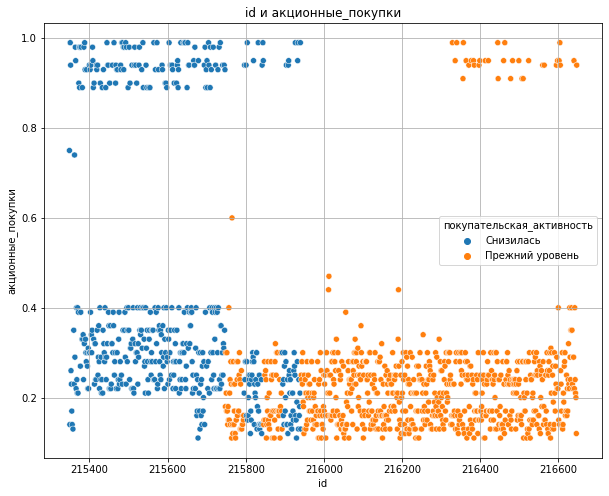

In [70]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=market_full.index, 
    y=market_full['акционные_покупки'], 
    hue=market_full['покупательская_активность'])
plt.title("id и акционные_покупки")
plt.xlabel("id")
plt.ylabel("акционные_покупки")
plt.grid(True)
plt.show()

Дополняя прошлый вывод, можно сказать, что старые пользователи гораздо чаще остаются на сайте ради акционных покупок, в то время как новые пользователи сохраняют прежний уровень активности. Есть, конечно, пользователи, которые покупают практически только продукты по акции, но их гораздо меньше, чем у старых пользователей.

Посмотрим по выручке

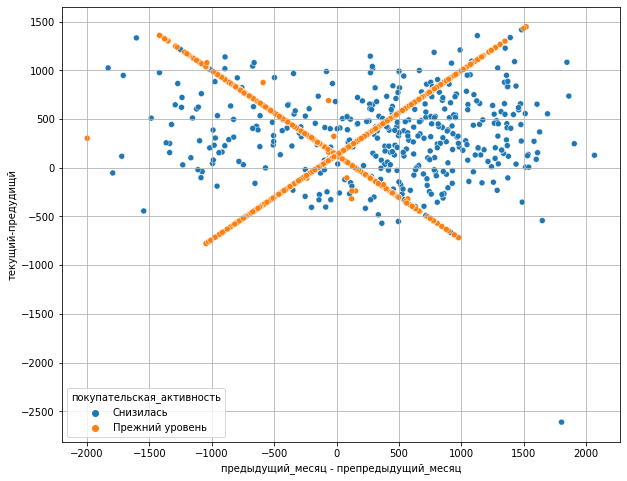

In [71]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=market_full['выручка_предыдущий_месяц'] - market_full['выручка_препредыдущий_месяц'],
    y=market_full['выручка_текущий_месяц'] - market_full['выручка_предыдущий_месяц'], 
    hue=market_full['покупательская_активность'])
plt.xlabel("предыдущий_месяц - препредыдущий_месяц")
plt.ylabel("текущий-предудищй")
plt.grid(True)
plt.show()

Тут уже не знаю, какие выводы можно сделать, тяжело как-то

## **Шаг 6. Использование пайплайнов**

Обучим KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC() используя пайплайны.

Для подготовки данных закодируем целевой признак в значения 1 и 0, и акционные_покупки преобразуем в категориальный признак. Также удалим столбцы выручка_предыдущий_месяц и выручка_препредыдущий_месяц

In [72]:
market_full['покупательская_активность'] = market_full['покупательская_активность'].apply(
    lambda x: 1 if x=='Снизилась' else 0)
market_full['покупательская_активность'] = market_full['покупательская_активность'].astype(int) 

In [73]:
market_full['акционные_покупки_частота'] = market_full['акционные_покупки'].apply(lambda x: 'Часто' if x>=0.5 else 'Редко')
market_full = market_full.drop(['акционные_покупки'], axis=1)

In [74]:
#market_full = market_full.drop(['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц'], axis=1)

In [75]:
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = y
)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [76]:
market_full.head(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,акционные_покупки_частота
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4.0,819.0,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6,Часто
215350,1,стандарт,нет,4.9,3.0,539.0,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4,Редко
215351,1,стандарт,да,3.2,5.0,896.0,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,Часто
215352,1,стандарт,нет,5.1,3.0,1064.0,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5,Часто
215353,1,стандарт,да,3.3,4.0,762.0,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5,Редко


In [77]:
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория', ]
ord_columns = ['акционные_покупки_частота']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'время_предыдущий_месяц', 
               'время_препредыдущий_месяц', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц']

In [78]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [79]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[['Часто','Редко']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [80]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [81]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 7),
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

In [83]:
%%time

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose = 3
)

CPU times: user 26 µs, sys: 5 µs, total: 31 µs
Wall time: 34.1 µs


In [84]:
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6, models__max_features=2, preprocessor__num=passthrough;, score=0.781 total time=   0.0s
[CV 2/5] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6, models__max_features=2, preprocessor__num=passthrough;, score=0.835 total time=   0.0s
[CV 3/5] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6, models__max_features=2, preprocessor__num=passthrough;, score=0.757 total time=   0.0s
[CV 4/5] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6, models__max_features=2, preprocessor__num=passthrough;, score=0.814 total time=   0.0s
[CV 5/5] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6, models__max_features=2, preprocessor__num=passthrough;, score=0.797 total time=   0.0s
[CV 1/5] END models=DecisionTreeClassifier(random_state=42), models__max_depth=4, models__max_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать',
                                                                                'популярная_категория']),...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc', verbose=3)

In [85]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)

In [86]:
print(f'Лучшая модель и ее параметры: {randomized_search.best_estimator_}')
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba[:,1])}')

Лучшая модель и ее параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                          

***Вывод***

Подготовили данные для обучения. 

Получили лучшую модель - LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear')
                                    
метрика ROC-AUC получилась отличной - 0.91

Выбрали ее по причине того, что она применяется в задачах бинарной классификации, где модель определяет, к какой категории относится объект, поэтому использовали ее

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Когда мы указываем метрику, то RandomizedSearchCV будет выбирать лучшие параметры, опираясь на значения ROC-AUC.</div>

## **Шаг 7. Анализ важности признаков**

In [87]:
best_model = randomized_search.best_estimator_

In [88]:
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['models']

In [89]:
X_train_transformed = preprocessor.transform(X_train)

In [90]:
ohe_feature_names = preprocessor.named_transformers_['ohe']\
    .named_steps['ohe'].get_feature_names_out(ohe_columns)

In [91]:
feature_names = list(ohe_feature_names) + ord_columns + num_columns

In [92]:
explainer = shap.Explainer(model, X_train_transformed, feature_names=feature_names)


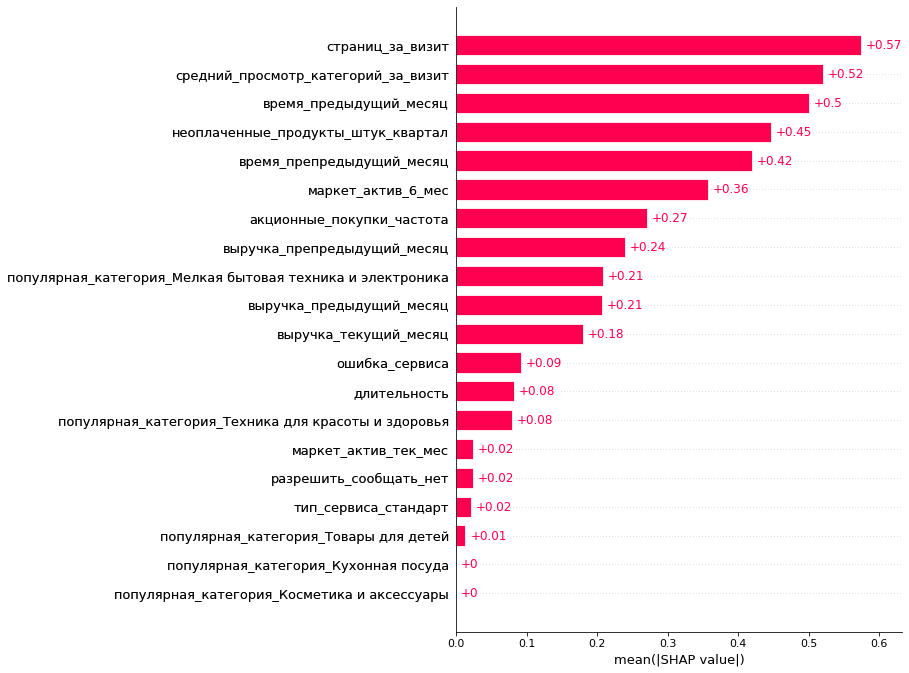

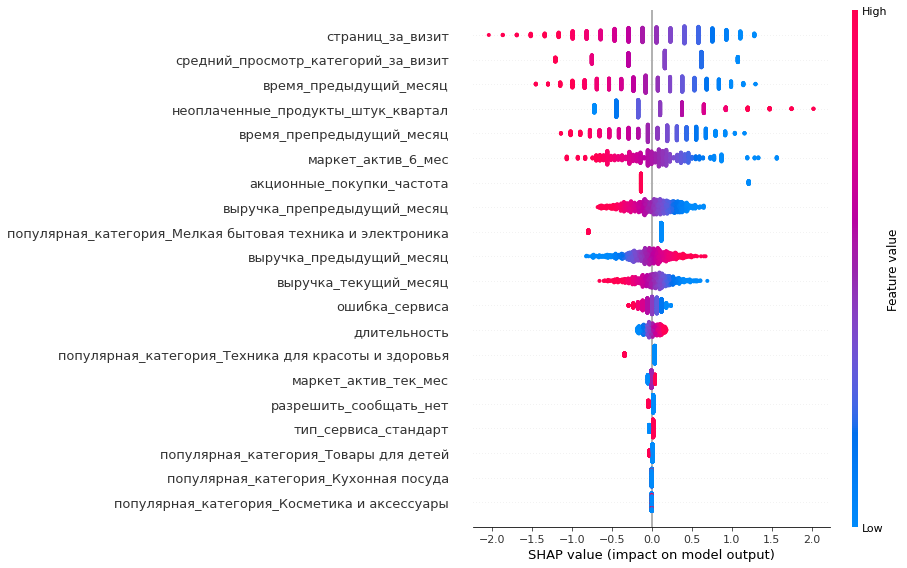

In [93]:
shap_values = explainer(X_train_transformed)
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)

***Вывод***

5 самых важных признаков это: страниц_за_визит, минут_предыдущий_месяц, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал и минут_текущий_месяц. В целом, логично. Чем больше пользователь смотрит страниц - тем сильнее склонность к тому, чтобы его активность осталась на прежнем уровне. Также время в прошлом месяце важный индикатор, динамику которого нужно отслеживать. Средний просмотр категории тоже важен - чем более разнообразный каталог, тем выше активность. Также стоит отметить, что частота акционных покупок тоже влияет - чем больше акционных покупок, тем больше вероятность того, что активность останется на прежнем уровне. Также есть значимость у неоплаченных продуктов. Чем их больше, тем больше вероятность того, что активность снизится.

Наименее важные признаки: категория (кроме бытовой техники), выручка_текущий_месяц, разрешать_сообщать, тип_сервиса, маркет_актив_тек_мес. 

Можно дать рекомендацию стараться удерживать клиента на сайте как можно дольше и предлагать ему различные категории, которые ему могут понравиться - например, сделать персональные подборки. Также есть много неоплаченных продуктов, нужно проследить, есть ли проблемы у пользователя с покупкой. 

## **Шаг 8. Сегментация покупателей**

In [94]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [95]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)

In [96]:
df_full

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,время_предыдущий_месяц,время_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,акционные_покупки_частота,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4.0,510.0,Мелкая бытовая техника и электроника,2,4,7,16,20,6,5170.5,4347.0,6014.2,Редко,0.067824,4.37
215361,стандарт,да,5.1,4.0,199.0,Техника для красоты и здоровья,4,5,2,3,11,13,6400.0,4597.0,3789.7,Редко,0.782626,4.03
215884,стандарт,да,4.3,5.0,997.0,Мелкая бытовая техника и электроника,5,1,3,11,13,10,4113.0,4626.0,3798.4,Редко,0.085136,4.37
216564,стандарт,да,5.6,4.0,342.0,Кухонная посуда,2,7,5,8,14,19,4930.0,5269.0,4766.2,Часто,0.662696,5.58
215715,премиум,да,3.6,5.0,873.0,Товары для детей,3,2,2,5,10,10,3716.0,4691.0,4600.0,Редко,0.743413,4.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215429,премиум,нет,0.9,4.0,690.0,Домашний текстиль,2,5,7,4,11,10,3662.0,4488.0,4158.6,Редко,0.969165,3.71
216233,премиум,да,3.9,4.0,1048.0,Техника для красоты и здоровья,3,0,6,14,15,17,4325.0,4553.0,4257.4,Редко,0.050957,4.62
215716,стандарт,да,2.4,4.0,952.0,Техника для красоты и здоровья,3,5,2,3,13,14,3067.0,4165.0,3343.9,Редко,0.888930,4.07


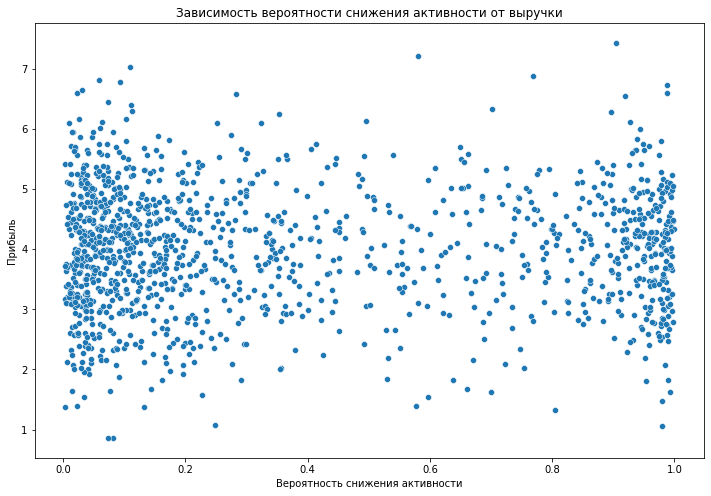

In [97]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

Явной зависимости нет

In [98]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(10,8))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title(f'Зависимость вероятности снижения активности от {cat_col}')
        plt.show()

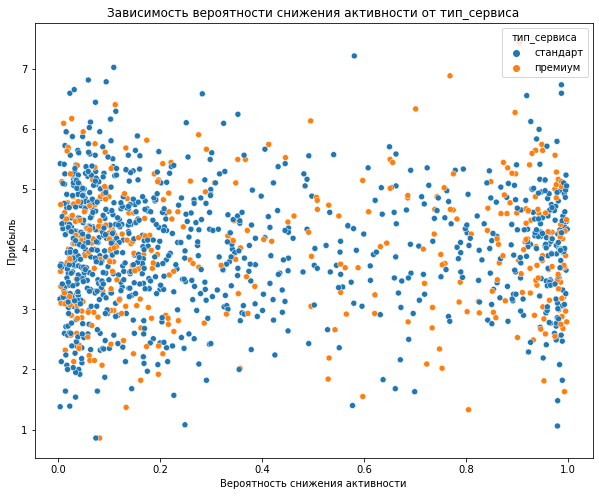

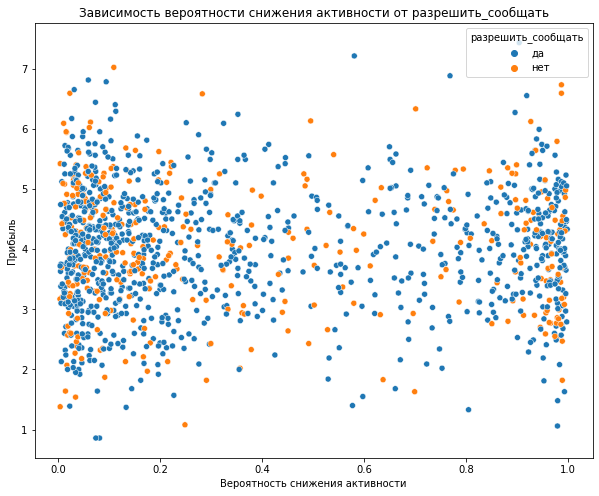

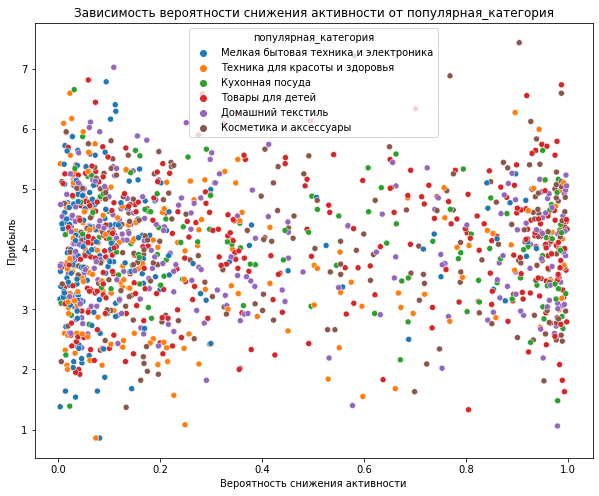

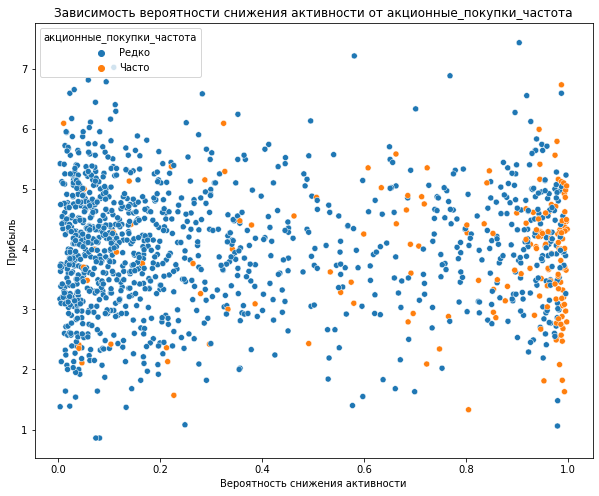

In [99]:
cat_columns = list(df_full.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

Больше всего бросается в глаза акционные_покупки_частота. Пользователи, которые часто покупают по акции, с большей вероятностью снизят активность.

Проанализируем этот сегмент

In [100]:
df_full['сегмент'] = df_full.apply(
        lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 \
        and row['акционные_покупки_частота']=='Часто' \
        else 'Остальные пользователи', axis=1)

In [101]:
def visualize_str_segment(data, columns):
    for column in columns:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        sns.countplot(x=column, data=data, ax=axes[0])
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].set_title(f'Гистограмма: {column}')
        
        axes[1].pie(data[column].value_counts(), labels=data[column].value_counts().index, autopct='%1.1f%%')
        axes[1].set_title(f'Круговая диаграмма: {column}')
    plt.show()

In [102]:
discount_segment = df_full[df_full['акционные_покупки_частота'] == 'Часто']

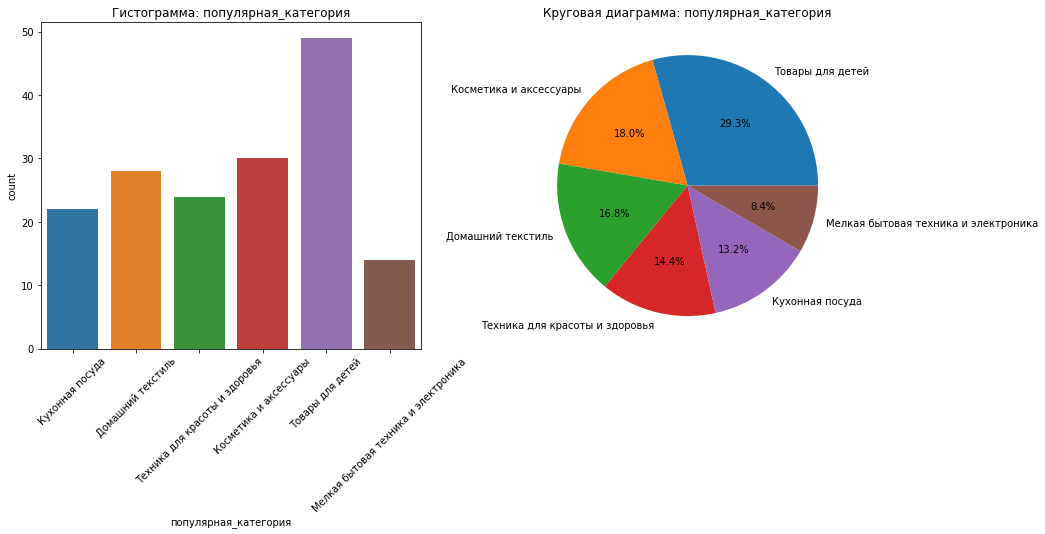

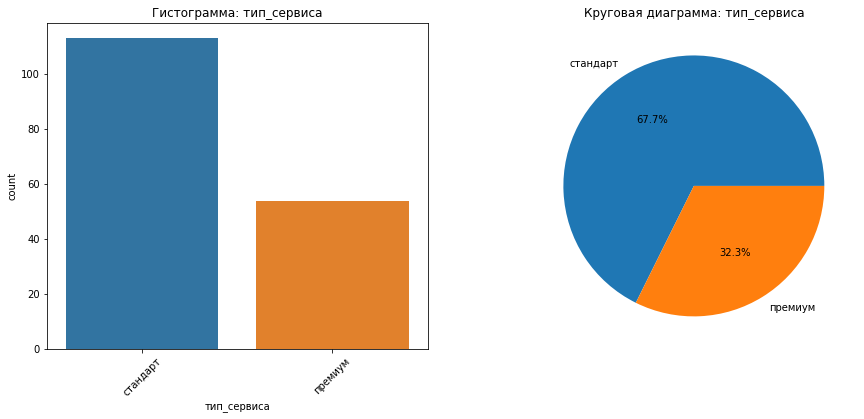

In [103]:
visualize_str_segment(discount_segment, ['популярная_категория', 'тип_сервиса'])

Товары для детей являются лидером у изучаемого сегмента

Также у 32% премиум-аккаунт

In [104]:
def visualize_num_segment(data, column):
    plt.figure(figsize=(8,6))
    sns.histplot(
        data=data,
        x=column,
        hue='сегмент',
        kde=True,
        bins=30,
        stat='count',
        palette='Set2',
    )
    plt.title(f'Распределение {column} по сегментам')
    plt.xlabel(column)
    plt.ylabel('Количество пользователей')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

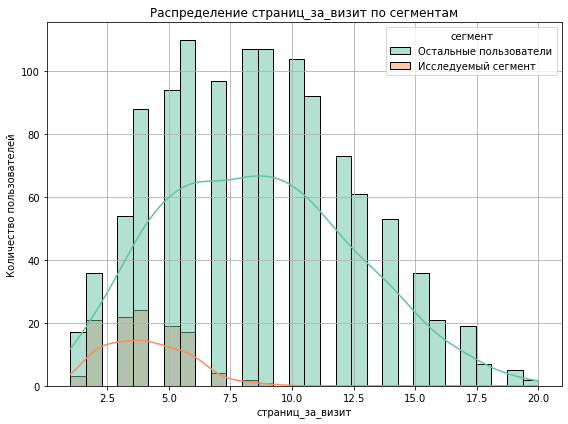

In [105]:
visualize_num_segment(df_full, 'страниц_за_визит')

График показывает, что изучаемый сегмент, в сравнении с остальными, мало просматривает страниц, что может говорить о том, что они целенаправленно ищут нужный товар по скидке

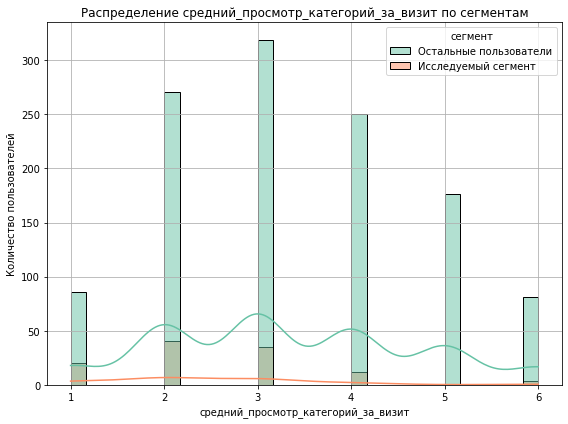

In [106]:
visualize_num_segment(df_full, 'средний_просмотр_категорий_за_визит')

Среднее количество просматриваемых категорий практически не отличается

Из способов увеличения прибыли - проведение акций для исследумой категории. Например, на детские товары, поскольку эта категория составляют бОльшую часть.  

## **Общий вывод**

Перед нами стояла задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Пройдемся по этапам работы

Предобработка данных

Изменили типы данных, нашли неявные дубликаты и исправили опечатки в столбцах

Исследовательский анализ данных

1. Покупательская активность в 61% случаев осталась прежней
2. У 71% пользователей стандартный тип сервиса
3. 74% пользователей можно отправлять дополнительные предложения
4. Явного фаворита в популярных категориях нет

Были найдены и устранены выбросы в таблице market_money

После обработки объединили таблицы

Корелляционный анализ данных

- Наблюдается зависимость между выручкой предыдущего месяца и текущего
- Также она есть у предыдущего и препредыдущего месяцев
- Также есть завиисмость между посещенными страницами и временем, проведенным на сайте, что логично
- Есть зависимость у минут_предыдущий_месяц и минут_текущий_месяц

Для устранения мультиколлениарности объединили столбцы выручка_препредыдущий_месяц и выручка_предыдущий_месяц в столбец выручка_2_пред_месяца

Обучение модели
Подготовили данные для обучения. 

Получили лучшую модель - LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear')
                                    
метрика ROC-AUC получилась отличной - 0.89

После анализа признаков получили следующие результаты:

5 самых важных признаков это: страниц_за_визит, минут_предыдущий_месяц, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал и минут_текущий_месяц. В целом, логично. Чем больше пользователь смотрит страниц - тем сильнее склонность к смене активности. Также время в прошлом месяце важный индикатор, динамику которого нужно отслеживать. Средний просмотр категории тоже важен - чем более разнообразный каталог, тем выше активность. 

Наименее важные признаки: категория (кроме бытовой техники), выручка_текущий_месяц, разрешать_сообщать, тип_сервиса, маркет_актив_тек_мес. 

После чего выделили сегмент, который с бОльшей вероятностью снизит активность - человек, который покупал по акции товары для детей, либо домашний текстиль. 

Для данного сегмента покупателей рекомендую увеличить количество акций по часто приобретаемым категориям, описанным выше. 


